# Homework 2 Exercise 1
Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

| Individual | height | expected weight  | 89% interval  |
|---|---|---|---|
| 1 | 140 |   |   |
| 2 | 160 |   |   |
| 3 | 175 |   |   |

In [1]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [2]:
@time data = CSV.read(sr_datadir("Howell1.csv"), DataFrame)

 10.454802 seconds (2.99 M allocations: 136.090 MiB, 0.36% gc time, 99.97% compilation time)


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


In [3]:
adults = data[data.age .>= 18 , :]

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


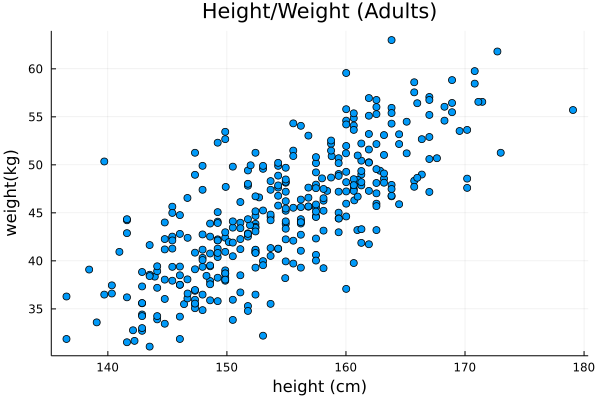

In [4]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm)", ylabel="weight(kg)", legend=false)

In [5]:
dt = standardize_column!(adults, :height, scale=false)

ZScoreTransform{Float64, Vector{Float64}}(1, 1, [154.59709261363633], Float64[])

In [6]:
@gen function adults_height_weight_model(heights)
    a ~ normal(40., 7.5) # somewhere around 40, in kg
    b ~ gamma(1, 3.) # how does weight scale with height, in kg/cm. However, don't forget that height was normalized.
    noise ~ gamma(1., 1.) # how far does the regression stray from reality
    
    function f(height)
        return a + b * height
    end
    
    for (i,height) in enumerate(heights)
        {(:y, i)} ~ normal(f(height), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##adults_height_weight_model#280", Bool[0], false)

Check how the priors are distributed:

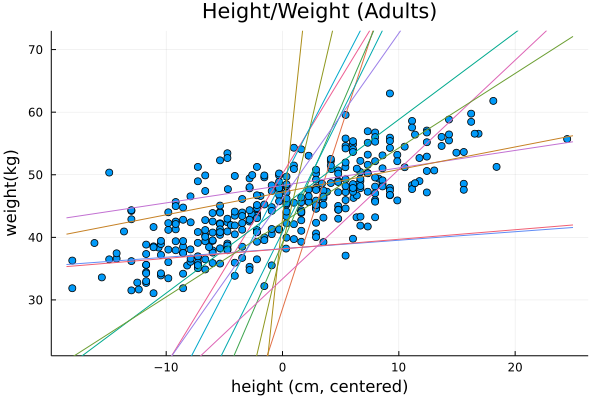

In [7]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", legend=false)
priors = [adults_height_weight_model(()) for _ in 1:15]
test_xs = range(minimum(adults.height)-0.5, maximum(adults.height)+0.5, length=1000)
plot!(test_xs, [f.(test_xs) for f in priors], legend=false)
plot!(ylim=(minimum(adults.weight) - 10, maximum(adults.weight) + 10))

In [8]:
observations = Gen.choicemap()
for (i,weight) in enumerate(adults.weight)
    observations[(:y, i)] = weight
end

num_samples=500
num_traces=100

@time traces = [Gen.importance_resampling(adults_height_weight_model, (adults.height,), observations, num_samples)[1] for _ in 1:num_traces]
as = Gen.get_value.(Gen.get_choices.(traces), :a)
bs = Gen.get_value.(Gen.get_choices.(traces), :b)
noises = Gen.get_value.(Gen.get_choices.(traces), :noise)
a = mean(as)
b = mean(bs)
noise = mean(noises);
a, b, noise

  8.305310 seconds (225.98 M allocations: 8.367 GiB, 9.75% gc time, 5.45% compilation time)


(44.67936848827539, 0.6360654687042919, 4.0175695983994375)

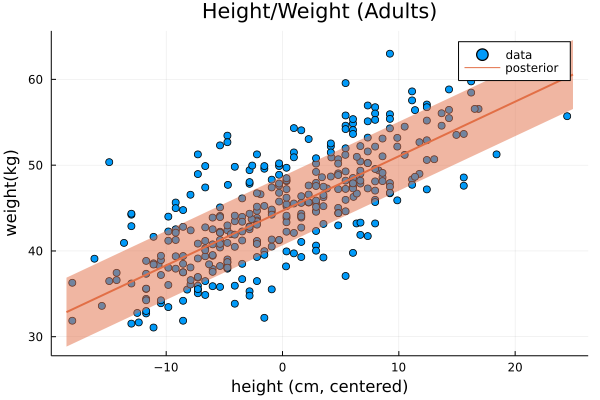

In [9]:
@df adults plot(:height, :weight, seriestype=:scatter, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data")
plot!(test_xs, (@. a + b * test_xs), linewidth=2., ribbon=noise, labels="posterior")

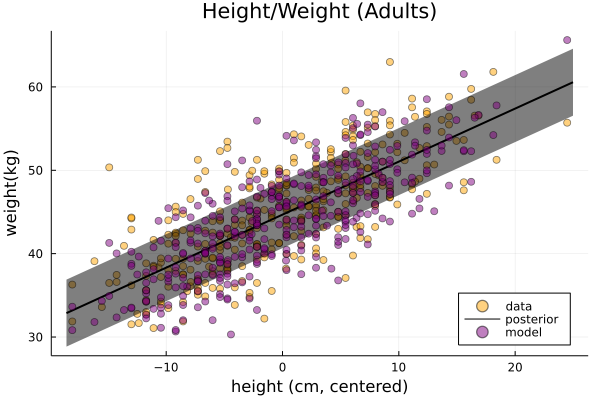

In [10]:
@df adults plot(:height, :weight, seriestype=:scatter, color=:orange, alpha=1/2, title="Height/Weight (Adults)", xlabel="height (cm, centered)", ylabel="weight(kg)", labels="data", legend=:bottomright)
plot!(test_xs, (@. a + b * test_xs), color=:black, ribbon=noise, labels="posterior", linewidth=2.)
test_predictions = @. rand(Normal(a + b * adults.height, noise))
plot!(adults.height, test_predictions, seriestype=:scatter, color=:purple, alpha=1/2, label="model")

In [11]:
to_predict = [140.,160.,175.]
StatsBase.transform!(dt, to_predict)
to_predict = reshape(to_predict, (1,length(to_predict)))

1×3 Matrix{Float64}:
 -14.5971  5.40291  20.4029

In [12]:
to_predict = repeat(to_predict, outer = 1000)
@time predictions = @. rand(Normal(a + b * to_predict, noise))

  0.077077 seconds (395.13 k allocations: 21.144 MiB, 98.25% compilation time)


1000×3 Matrix{Float64}:
 38.8067  42.3975  58.7334
 38.9433  43.7598  57.9328
 30.554   45.5789  54.2169
 37.3941  49.3035  62.7198
 30.3308  44.7687  59.1378
 34.8373  40.8329  54.745
 26.9277  50.9236  56.6996
 37.984   43.93    53.3395
 31.8041  49.0998  64.3681
 35.4825  51.3109  59.4694
 31.4766  50.9301  62.7324
 35.0552  44.3491  54.8013
 32.4098  41.8209  58.7082
  ⋮                
 31.5518  43.4435  61.8773
 39.2661  51.4632  56.5211
 37.4937  53.1287  67.3631
 33.6896  57.2504  59.7606
 36.7686  47.4083  60.4533
 30.855   51.5296  61.9782
 33.5696  46.9973  57.8019
 36.7045  46.7039  55.2109
 36.005   55.4238  56.6577
 39.4808  49.9585  60.2837
 34.5671  53.9252  56.7574
 21.6917  47.8053  52.8092

In [13]:
ew1, ew2, ew3 = round.(mean(predictions, dims=1), digits=2)

1×3 Matrix{Float64}:
 35.43  47.89  57.52

In [14]:
i1 = round.(PI(predictions[:,1]), digits=2)
i2 = round.(PI(predictions[:, 2]), digits=2)
i3 = round.(PI(predictions[:, 3]), digits=2)
i1, i2, i3

([29.18, 41.63], [41.51, 54.11], [51.12, 63.93])

In [15]:
@info "\n| Individual | height | expected weight |  89% interval  |
|------------|--------|-----------------|----------------|
|          1 |    140 |           $ew1 | $i1 |
|          2 |    160 |           $ew2 | $i2 |
|          3 |    175 |           $ew3 | $i3 |"

┌ Info: 
│ | Individual | height | expected weight |  89% interval  |
│ |------------|--------|-----------------|----------------|
│ |          1 |    140 |           35.43 | [29.18, 41.63] |
│ |          2 |    160 |           47.89 | [41.51, 54.11] |
│ |          3 |    175 |           57.52 | [51.12, 63.93] |
└ @ Main In[15]:1
